In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines.utils import concordance_index

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.cluster import KMeans
from sklearn.metrics import (adjusted_rand_score, normalized_mutual_info_score, confusion_matrix,
                              accuracy_score, f1_score, precision_score, recall_score, roc_auc_score,
                              silhouette_score, calinski_harabasz_score, davies_bouldin_score)
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from torch_geometric.nn import GATConv, GCNConv
from torch_geometric.data import Data
from torch_geometric.nn import knn_graph


torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
print(f'Importing Data_preprocess_3Omics processed datasets for direct fusion analysis')
print("=" * 80)

# Load the preprocessed datasets from Data_preprocess_3Omics pipeline
print("🔄 Loading preprocessed datasets...")
expression_scaled2 = pd.read_csv("../NewDatasets/processed_expression_FXS_OG.csv", index_col=0)
methylation_scaled2 = pd.read_csv("../NewDatasets/processed_methylation_FXS_OG.csv", index_col=0)
copy_number_scaled2 = pd.read_csv("../NewDatasets/processed_cnv_FXS_OG.csv", index_col=0)
phenotype_data_clean2 = pd.read_csv("../NewDatasets/processed_phenotype_FXS_OG.csv", index_col=0)
labels = pd.read_csv("../NewDatasets/processed_labels_3Omics_FXS_OG.csv", index_col=0)

print("📊 Original Dataset Shapes (Features x Samples):")
print(f"   Expression: {expression_scaled2.shape} (genes x samples)")
print(f"   Methylation: {methylation_scaled2.shape} (CpG sites x samples)")
print(f"   Copy Number: {copy_number_scaled2.shape} (regions x samples)")
print(f"   Phenotype: {phenotype_data_clean2.shape} (samples x features)")
print(f"   Labels: {labels.shape} (samples)")

# Transpose omics data to have samples as rows (required for ML models)
print("\n🔄 Transposing omics data (samples as rows)...")
expression_scaled2 = expression_scaled2.T  # Now (samples x genes)
methylation_scaled2 = methylation_scaled2.T  # Now (samples x CpG sites)
copy_number_scaled2 = copy_number_scaled2.T  # Now (samples x regions)

# Apply variance threshold (0.1) before StandardScaler
vt = VarianceThreshold(threshold=0.1)
expression_scaled2 = pd.DataFrame(
    vt.fit_transform(expression_scaled2),
    index=expression_scaled2.index,
    columns=expression_scaled2.columns[vt.get_support()]
)
vt = VarianceThreshold(threshold=0.1)
methylation_scaled2 = pd.DataFrame(
    vt.fit_transform(methylation_scaled2),
    index=methylation_scaled2.index,
    columns=methylation_scaled2.columns[vt.get_support()]
)
vt = VarianceThreshold(threshold=0.1)
copy_number_scaled2 = pd.DataFrame(
    vt.fit_transform(copy_number_scaled2),
    index=copy_number_scaled2.index,
    columns=copy_number_scaled2.columns[vt.get_support()]
)

expression_scaled2 = pd.DataFrame(
    StandardScaler().fit_transform(expression_scaled2),
    index=expression_scaled2.index,
    columns=expression_scaled2.columns
)

methylation_scaled2 = pd.DataFrame(
    StandardScaler().fit_transform(methylation_scaled2),
    index=methylation_scaled2.index,
    columns=methylation_scaled2.columns
)

copy_number_scaled2 = pd.DataFrame(
    StandardScaler().fit_transform(copy_number_scaled2),
    index=copy_number_scaled2.index,
    columns=copy_number_scaled2.columns
)

print("\n✅ Omics data standardized (samples as rows, features scaled column-wise).")
# print("Expression data (final scaled shape):", expression_scaled_final.shape)

print("📊 After transpose (Samples x Features):")
print(f"   Expression: {expression_scaled2.shape} (samples x genes)")
print(f"   Methylation: {methylation_scaled2.shape} (samples x CpG sites)")
print(f"   Copy Number: {copy_number_scaled2.shape} (samples x regions)")

# Verify data quality (should have no missing values from preprocessing)
print("\n🔍 Data Quality Check:")
print(f"   Expression missing values: {expression_scaled2.isnull().sum().sum()}")
print(f"   Methylation missing values: {methylation_scaled2.isnull().sum().sum()}")
print(f"   Copy Number missing values: {copy_number_scaled2.isnull().sum().sum()}")
print(f"   Labels missing values: {labels.isnull().sum().sum()}")

# Check sample alignment (should be perfect from preprocessing)
common_samples_check = [
    set(expression_scaled2.index),
    set(methylation_scaled2.index), 
    set(copy_number_scaled2.index),
    set(labels.index)
]

all_aligned = all(s == common_samples_check[0] for s in common_samples_check)
print(f"\n✅ Sample alignment: {'Perfect' if all_aligned else 'Misaligned'}")
print(f"📊 Total samples: {len(expression_scaled2)}")


Importing Data_preprocess_3Omics processed datasets for direct fusion analysis
🔄 Loading preprocessed datasets...
📊 Original Dataset Shapes (Features x Samples):
   Expression: (44663, 205) (genes x samples)
   Methylation: (419542, 205) (CpG sites x samples)
   Copy Number: (56756, 205) (regions x samples)
   Phenotype: (205, 78) (samples x features)
   Labels: (205, 1) (samples)

🔄 Transposing omics data (samples as rows)...

✅ Omics data standardized (samples as rows, features scaled column-wise).
📊 After transpose (Samples x Features):
   Expression: (205, 18608) (samples x genes)
   Methylation: (205, 388929) (samples x CpG sites)
   Copy Number: (205, 56756) (samples x regions)

🔍 Data Quality Check:
   Expression missing values: 0
   Methylation missing values: 0
   Copy Number missing values: 0
   Labels missing values: 0

✅ Sample alignment: Perfect
📊 Total samples: 205


In [24]:
# Apply PCA to Individual Omics First, Then Create Fusion
print("Applying PCA to Individual Omics, Then Creating Fusion...")
print("=" * 80)

# PCA components for each omic type
pca_components = {
    'expression': 50,
    'methylation': 120, 
    'cnv': 70
}

pca_expression = PCA(n_components=pca_components['expression'], random_state=42)
expression_pca = pd.DataFrame(
    pca_expression.fit_transform(expression_scaled2),
    index=expression_scaled2.index,
    columns=[f'Expr_PC{i+1}' for i in range(pca_components['expression'])]
)

pca_methylation = PCA(n_components=pca_components['methylation'], random_state=42)
methylation_pca = pd.DataFrame(
    pca_methylation.fit_transform(methylation_scaled2),
    index=methylation_scaled2.index,
    columns=[f'Meth_PC{i+1}' for i in range(pca_components['methylation'])]
)

pca_cnv = PCA(n_components=pca_components['cnv'], random_state=42)
cnv_pca = pd.DataFrame(
    pca_cnv.fit_transform(copy_number_scaled2),
    index=copy_number_scaled2.index,
    columns=[f'CNV_PC{i+1}' for i in range(pca_components['cnv'])]
)

print(f"\n🔗 Creating Fusion from Individual PCA Results...")
fpca_individual_fusion = pd.concat([
    expression_pca,
    methylation_pca, 
    cnv_pca
], axis=1)

# Verify no missing values
print(f"\n🔍 Data Quality Check:")
print(f"   Individual PCA fusion missing values: {fpca_individual_fusion.isnull().sum().sum()}")

Applying PCA to Individual Omics, Then Creating Fusion...

🔗 Creating Fusion from Individual PCA Results...

🔍 Data Quality Check:
   Individual PCA fusion missing values: 0

🔗 Creating Fusion from Individual PCA Results...

🔍 Data Quality Check:
   Individual PCA fusion missing values: 0


# Autoencoder-Based Analysis Pipeline

This section implements autoencoder-based dimensionality reduction followed by machine learning classification.

In [31]:
# Autoencoder Class and Training Function
print("AUTOENCODER ARCHITECTURE DEFINITION")
print("=" * 80)

class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=64, dropout=0.3):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, input_dim)
        )
    
    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

class ShallowAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=64, dropout=0.3):
        super(ShallowAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, latent_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, input_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
    
    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

def train_autoencoder(model, data, device, epochs=300, lr=0.001, patience=15):
    # Split data for training and validation
    data_np = data.cpu().numpy() if torch.is_tensor(data) else data
    X_train, X_val = train_test_split(data_np, test_size=0.2, random_state=42)
    
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    X_val_tensor = torch.FloatTensor(X_val).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.MSELoss()
    
    train_losses = []
    val_losses = []
    best_val_loss = np.inf
    best_model_state = None
    patience_counter = 0
    
    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        x_recon, _ = model(X_train_tensor)
        train_loss = criterion(x_recon, X_train_tensor)
        train_loss.backward()
        optimizer.step()
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_recon, _ = model(X_val_tensor)
            val_loss = criterion(val_recon, X_val_tensor)
        
        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())
        
        # Early stopping check
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"   Early stopping at epoch {epoch+1}")
            break
    
    # Restore best model
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    return model, {'train_losses': train_losses, 'val_losses': val_losses}

print("✅ Autoencoder classes and training function defined!")
print(f"   Deep Architecture: Input → 256 → Latent → 256 → Output (2 layers)")
print(f"   Shallow Architecture: Input → Latent → Output (1 layer)")
print(f"   Features: Dropout regularization, early stopping, MSE loss")

AUTOENCODER ARCHITECTURE DEFINITION
✅ Autoencoder classes and training function defined!
   Deep Architecture: Input → 256 → Latent → 256 → Output (2 layers)
   Shallow Architecture: Input → Latent → Output (1 layer)
   Features: Dropout regularization, early stopping, MSE loss


In [32]:
# ML Models Evaluation Function
print("MACHINE LEARNING MODELS DEFINITION")
print("=" * 80)

def evaluate_ml_models_on_embeddings(embeddings, labels, k_folds=5):
    """
    Evaluate multiple ML classifiers on autoencoder embeddings
    
    Args:
        embeddings: Latent representations from autoencoder
        labels: Target labels
        k_folds: Number of cross-validation folds
        
    Returns:
        Dictionary with comprehensive metrics for each model
    """
    models = {
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10),
        'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=5),
        'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr'),
        'SVM_RBF': SVC(kernel='rbf', random_state=42, probability=True),
        'KNN': KNeighborsClassifier(n_neighbors=4),
        'NaiveBayes': GaussianNB()
    }
    
    results = {}
    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    # Split data into train and test sets for proper evaluation
    X_train, X_test, y_train, y_test = train_test_split(
        embeddings, labels, test_size=0.2, random_state=42, stratify=labels
    )
    
    for model_name, model in models.items():
        print(f"\n⚙️  Training {model_name}...")
        
        # Cross-validation scores (on full data for comparison)
        cv_scores = cross_val_score(model, embeddings, labels, cv=skf, scoring='accuracy')
        
        # Train on train set and evaluate on test set (PROPER EVALUATION)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)
        
        # Calculate comprehensive metrics on TEST SET
        accuracy = accuracy_score(y_test, y_pred)
        f1_macro = f1_score(y_test, y_pred, average='macro')
        f1_micro = f1_score(y_test, y_pred, average='micro')
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        
        # AUC (one-vs-rest for multiclass)
        try:
            n_classes = len(np.unique(y_test))
            if n_classes == 2:
                auc = roc_auc_score(y_test, y_pred_proba[:, 1])
            else:
                y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
                auc = roc_auc_score(y_test_bin, y_pred_proba, average='macro', multi_class='ovr')
        except:
            auc = None
        
        # C-index (concordance index)
        try:
            c_index = concordance_index(y_test, y_pred_proba.max(axis=1))
        except:
            c_index = None
        
        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        
        results[model_name] = {
            'accuracy': accuracy,
            'f1_macro': f1_macro,
            'f1_micro': f1_micro,
            'precision': precision,
            'recall': recall,
            'auc': auc,
            'c_index': c_index,
            'cv_scores': cv_scores,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'confusion_matrix': cm
        }
        
        print(f"   ✅ {model_name}: Accuracy={accuracy:.4f}, F1_macro={f1_macro:.4f}, F1_micro={f1_micro:.4f}")
    
    return results

print("✅ ML evaluation function defined!")
print(f"   Models: RandomForest, GradientBoosting, LogisticRegression, SVM, KNN, NaiveBayes")
print(f"   Metrics: accuracy, f1_macro, f1_micro, precision, recall, AUC, c-index, CV scores")

MACHINE LEARNING MODELS DEFINITION
✅ ML evaluation function defined!
   Models: RandomForest, GradientBoosting, LogisticRegression, SVM, KNN, NaiveBayes
   Metrics: accuracy, f1_macro, f1_micro, precision, recall, AUC, c-index, CV scores


In [33]:
# Execute Autoencoder Pipeline and Store Results
print("AUTOENCODER PIPELINE EXECUTION")
print("=" * 80)

# Initialize results dictionaries
ae_scores = {}  # Deep autoencoder results
shallow_ae_scores = {}  # Shallow autoencoder results
ae_embeddings = {}  # Store embeddings for visualization
shallow_ae_embeddings = {}  # Store shallow embeddings for visualization

# Latent dimensions to test
latent_dims = [64, 128]

# Device setup
print(f"🖥️  Using device: {device}\n")

# Use the single fusion data
fusion_data = fpca_individual_fusion.values
print(f"🔬 Processing Individual PCA Fusion: {fusion_data.shape}")
print("=" * 80)

# Prepare data once
X = fusion_data
y = labels.values.ravel()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_tensor = torch.FloatTensor(X_scaled).to(device)

for latent_dim in latent_dims:
    print(f"\n📊 Latent Dimension: {latent_dim}")
    print("=" * 80)
    
    # ============================================================================
    # DEEP AUTOENCODER
    # ============================================================================
    print(f"🧠 Training Deep Autoencoder (latent_dim={latent_dim})...")
    ae_model = Autoencoder(input_dim=X_scaled.shape[1], latent_dim=latent_dim).to(device)
    ae_model, history = train_autoencoder(ae_model, X_tensor, device, epochs=100, patience=15)
    
    # Extract deep autoencoder latent embeddings
    ae_model.eval()
    with torch.no_grad():
        _, embeddings_deep = ae_model(X_tensor)
        embeddings_deep_np = embeddings_deep.cpu().numpy()
    
    print(f"   ✅ Deep AE Embeddings shape: {embeddings_deep_np.shape}")
    
    # Evaluate ML models on deep autoencoder embeddings
    print(f"\n🤖 Evaluating ML Models on Deep AE Embeddings...")
    ml_results_deep = evaluate_ml_models_on_embeddings(embeddings_deep_np, y, k_folds=5)
    
    # Calculate clustering metrics for deep autoencoder
    print(f"\n📈 Computing Deep AE Clustering Metrics...")
    n_clusters = len(np.unique(y))
    kmeans_deep = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels_deep = kmeans_deep.fit_predict(embeddings_deep_np)
    
    ari_deep = adjusted_rand_score(y, cluster_labels_deep)
    nmi_deep = normalized_mutual_info_score(y, cluster_labels_deep)
    silhouette_deep = silhouette_score(embeddings_deep_np, cluster_labels_deep)
    calinski_deep = calinski_harabasz_score(embeddings_deep_np, cluster_labels_deep)
    davies_deep = davies_bouldin_score(embeddings_deep_np, cluster_labels_deep)
    
    print(f"   Deep AE - ARI: {ari_deep:.4f} | NMI: {nmi_deep:.4f} | Silhouette: {silhouette_deep:.4f}")
    print(f"   Deep AE - Calinski-Harabasz: {calinski_deep:.2f} | Davies-Bouldin: {davies_deep:.4f}")
    
    # Deep autoencoder reconstruction error
    ae_model.eval()
    with torch.no_grad():
        recon_deep, _ = ae_model(X_tensor)
        recon_error_deep = nn.MSELoss()(recon_deep, X_tensor).item()
    
    # Store deep autoencoder results
    ae_scores[latent_dim] = {
        'latent_dim': latent_dim,
        'ml_models': ml_results_deep,
        'ari': ari_deep,
        'nmi': nmi_deep,
        'silhouette': silhouette_deep,
        'calinski_harabasz': calinski_deep,
        'davies_bouldin': davies_deep,
        'reconstruction_error': recon_error_deep,
        'embeddings_shape': embeddings_deep_np.shape,
        'train_history': history
    }
    
    # Store deep autoencoder embeddings for visualization
    ae_embeddings[latent_dim] = embeddings_deep_np
    
    print(f"\n✅ Deep AE results saved for latent dimension {latent_dim}")
    
    # ============================================================================
    # SHALLOW AUTOENCODER
    # ============================================================================
    print(f"\n🧠 Training Shallow Autoencoder (latent_dim={latent_dim})...")
    shallow_ae_model = ShallowAutoencoder(input_dim=X_scaled.shape[1], latent_dim=latent_dim).to(device)
    shallow_ae_model, shallow_history = train_autoencoder(shallow_ae_model, X_tensor, device, epochs=100, patience=15)
    
    # Extract shallow autoencoder latent embeddings
    shallow_ae_model.eval()
    with torch.no_grad():
        _, embeddings_shallow = shallow_ae_model(X_tensor)
        embeddings_shallow_np = embeddings_shallow.cpu().numpy()
    
    print(f"   ✅ Shallow AE Embeddings shape: {embeddings_shallow_np.shape}")
    
    # Evaluate ML models on shallow autoencoder embeddings
    print(f"\n🤖 Evaluating ML Models on Shallow AE Embeddings...")
    ml_results_shallow = evaluate_ml_models_on_embeddings(embeddings_shallow_np, y, k_folds=5)
    
    # Calculate clustering metrics for shallow autoencoder
    print(f"\n📈 Computing Shallow AE Clustering Metrics...")
    kmeans_shallow = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels_shallow = kmeans_shallow.fit_predict(embeddings_shallow_np)
    
    ari_shallow = adjusted_rand_score(y, cluster_labels_shallow)
    nmi_shallow = normalized_mutual_info_score(y, cluster_labels_shallow)
    silhouette_shallow = silhouette_score(embeddings_shallow_np, cluster_labels_shallow)
    calinski_shallow = calinski_harabasz_score(embeddings_shallow_np, cluster_labels_shallow)
    davies_shallow = davies_bouldin_score(embeddings_shallow_np, cluster_labels_shallow)
    
    print(f"   Shallow AE - ARI: {ari_shallow:.4f} | NMI: {nmi_shallow:.4f} | Silhouette: {silhouette_shallow:.4f}")
    print(f"   Shallow AE - Calinski-Harabasz: {calinski_shallow:.2f} | Davies-Bouldin: {davies_shallow:.4f}")
    
    # Shallow autoencoder reconstruction error
    shallow_ae_model.eval()
    with torch.no_grad():
        recon_shallow, _ = shallow_ae_model(X_tensor)
        recon_error_shallow = nn.MSELoss()(recon_shallow, X_tensor).item()
    
    # Store shallow autoencoder results
    shallow_ae_scores[latent_dim] = {
        'latent_dim': latent_dim,
        'ml_models': ml_results_shallow,
        'ari': ari_shallow,
        'nmi': nmi_shallow,
        'silhouette': silhouette_shallow,
        'calinski_harabasz': calinski_shallow,
        'davies_bouldin': davies_shallow,
        'reconstruction_error': recon_error_shallow,
        'embeddings_shape': embeddings_shallow_np.shape,
        'train_history': shallow_history
    }
    
    # Store shallow autoencoder embeddings for visualization
    shallow_ae_embeddings[latent_dim] = embeddings_shallow_np
    
    print(f"\n✅ Shallow AE results saved for latent dimension {latent_dim}")

print(f"\n{'='*80}")
print(f"🎉 AUTOENCODER PIPELINES COMPLETED!")
print(f"{'='*80}")
print(f"Deep AE latent dimensions evaluated: {list(ae_scores.keys())}")
print(f"Shallow AE latent dimensions evaluated: {list(shallow_ae_scores.keys())}")
print(f"Results stored in 'ae_scores' and 'shallow_ae_scores' dictionaries")

AUTOENCODER PIPELINE EXECUTION
🖥️  Using device: cuda

🔬 Processing Individual PCA Fusion: (205, 240)

📊 Latent Dimension: 64
🧠 Training Deep Autoencoder (latent_dim=64)...
   ✅ Deep AE Embeddings shape: (205, 64)

🤖 Evaluating ML Models on Deep AE Embeddings...

⚙️  Training RandomForest...
   ✅ Deep AE Embeddings shape: (205, 64)

🤖 Evaluating ML Models on Deep AE Embeddings...

⚙️  Training RandomForest...


f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


   ✅ RandomForest: Accuracy=0.6341, F1_macro=0.4067, F1_micro=0.6341

⚙️  Training GradientBoosting...
   ✅ GradientBoosting: Accuracy=0.5122, F1_macro=0.3333, F1_micro=0.5122

⚙️  Training LogisticRegression...
   ✅ LogisticRegression: Accuracy=0.7073, F1_macro=0.6171, F1_micro=0.7073

⚙️  Training SVM_RBF...
   ✅ SVM_RBF: Accuracy=0.6098, F1_macro=0.3503, F1_micro=0.6098

⚙️  Training KNN...
   ✅ KNN: Accuracy=0.5122, F1_macro=0.3698, F1_micro=0.5122

⚙️  Training NaiveBayes...
   ✅ NaiveBayes: Accuracy=0.4146, F1_macro=0.3130, F1_micro=0.4146

📈 Computing Deep AE Clustering Metrics...
   ✅ GradientBoosting: Accuracy=0.5122, F1_macro=0.3333, F1_micro=0.5122

⚙️  Training LogisticRegression...
   ✅ LogisticRegression: Accuracy=0.7073, F1_macro=0.6171, F1_micro=0.7073

⚙️  Training SVM_RBF...
   ✅ SVM_RBF: Accuracy=0.6098, F1_macro=0.3503, F1_micro=0.6098

⚙️  Training KNN...
   ✅ KNN: Accuracy=0.5122, F1_macro=0.3698, F1_micro=0.5122

⚙️  Training NaiveBayes...
   ✅ NaiveBayes: Accura

f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATA

   Deep AE - ARI: 0.0594 | NMI: 0.1336 | Silhouette: 0.0414
   Deep AE - Calinski-Harabasz: 3.57 | Davies-Bouldin: 4.0942

✅ Deep AE results saved for latent dimension 64

🧠 Training Shallow Autoencoder (latent_dim=64)...
   ✅ Shallow AE Embeddings shape: (205, 64)

🤖 Evaluating ML Models on Shallow AE Embeddings...

⚙️  Training RandomForest...
   ✅ Shallow AE Embeddings shape: (205, 64)

🤖 Evaluating ML Models on Shallow AE Embeddings...

⚙️  Training RandomForest...


f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


   ✅ RandomForest: Accuracy=0.5854, F1_macro=0.3757, F1_micro=0.5854

⚙️  Training GradientBoosting...
   ✅ GradientBoosting: Accuracy=0.5610, F1_macro=0.4148, F1_micro=0.5610

⚙️  Training LogisticRegression...
   ✅ LogisticRegression: Accuracy=0.5854, F1_macro=0.4485, F1_micro=0.5854

⚙️  Training SVM_RBF...
   ✅ SVM_RBF: Accuracy=0.5610, F1_macro=0.3030, F1_micro=0.5610

⚙️  Training KNN...
   ✅ KNN: Accuracy=0.3659, F1_macro=0.2646, F1_micro=0.3659

⚙️  Training NaiveBayes...
   ✅ NaiveBayes: Accuracy=0.4390, F1_macro=0.3165, F1_micro=0.4390

📈 Computing Shallow AE Clustering Metrics...
   ✅ GradientBoosting: Accuracy=0.5610, F1_macro=0.4148, F1_micro=0.5610

⚙️  Training LogisticRegression...
   ✅ LogisticRegression: Accuracy=0.5854, F1_macro=0.4485, F1_micro=0.5854

⚙️  Training SVM_RBF...
   ✅ SVM_RBF: Accuracy=0.5610, F1_macro=0.3030, F1_micro=0.5610

⚙️  Training KNN...
   ✅ KNN: Accuracy=0.3659, F1_macro=0.2646, F1_micro=0.3659

⚙️  Training NaiveBayes...
   ✅ NaiveBayes: Acc

f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATA

   Shallow AE - ARI: -0.0394 | NMI: 0.0391 | Silhouette: 0.0722
   Shallow AE - Calinski-Harabasz: 5.08 | Davies-Bouldin: 3.8650

✅ Shallow AE results saved for latent dimension 64

📊 Latent Dimension: 128
🧠 Training Deep Autoencoder (latent_dim=128)...
   ✅ Deep AE Embeddings shape: (205, 128)

🤖 Evaluating ML Models on Deep AE Embeddings...

⚙️  Training RandomForest...
   ✅ Deep AE Embeddings shape: (205, 128)

🤖 Evaluating ML Models on Deep AE Embeddings...

⚙️  Training RandomForest...


f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


   ✅ RandomForest: Accuracy=0.5366, F1_macro=0.2817, F1_micro=0.5366

⚙️  Training GradientBoosting...
   ✅ GradientBoosting: Accuracy=0.6098, F1_macro=0.4411, F1_micro=0.6098

⚙️  Training LogisticRegression...
   ✅ LogisticRegression: Accuracy=0.7317, F1_macro=0.6333, F1_micro=0.7317

⚙️  Training SVM_RBF...
   ✅ SVM_RBF: Accuracy=0.5854, F1_macro=0.3265, F1_micro=0.5854

⚙️  Training KNN...
   ✅ KNN: Accuracy=0.4878, F1_macro=0.2935, F1_micro=0.4878

⚙️  Training NaiveBayes...
   ✅ GradientBoosting: Accuracy=0.6098, F1_macro=0.4411, F1_micro=0.6098

⚙️  Training LogisticRegression...
   ✅ LogisticRegression: Accuracy=0.7317, F1_macro=0.6333, F1_micro=0.7317

⚙️  Training SVM_RBF...
   ✅ SVM_RBF: Accuracy=0.5854, F1_macro=0.3265, F1_micro=0.5854

⚙️  Training KNN...
   ✅ KNN: Accuracy=0.4878, F1_macro=0.2935, F1_micro=0.4878

⚙️  Training NaiveBayes...


f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATA

   ✅ NaiveBayes: Accuracy=0.4634, F1_macro=0.3458, F1_micro=0.4634

📈 Computing Deep AE Clustering Metrics...
   Deep AE - ARI: -0.0175 | NMI: 0.0161 | Silhouette: 0.1022
   Deep AE - Calinski-Harabasz: 3.12 | Davies-Bouldin: 3.6362

✅ Deep AE results saved for latent dimension 128

🧠 Training Shallow Autoencoder (latent_dim=128)...
   ✅ Shallow AE Embeddings shape: (205, 128)

🤖 Evaluating ML Models on Shallow AE Embeddings...

⚙️  Training RandomForest...
   ✅ Shallow AE Embeddings shape: (205, 128)

🤖 Evaluating ML Models on Shallow AE Embeddings...

⚙️  Training RandomForest...


f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


   ✅ RandomForest: Accuracy=0.6098, F1_macro=0.3675, F1_micro=0.6098

⚙️  Training GradientBoosting...
   ✅ GradientBoosting: Accuracy=0.6098, F1_macro=0.4989, F1_micro=0.6098

⚙️  Training LogisticRegression...
   ✅ LogisticRegression: Accuracy=0.6585, F1_macro=0.4792, F1_micro=0.6585

⚙️  Training SVM_RBF...
   ✅ SVM_RBF: Accuracy=0.5854, F1_macro=0.3290, F1_micro=0.5854

⚙️  Training KNN...
   ✅ KNN: Accuracy=0.6829, F1_macro=0.4037, F1_micro=0.6829

⚙️  Training NaiveBayes...
   ✅ GradientBoosting: Accuracy=0.6098, F1_macro=0.4989, F1_micro=0.6098

⚙️  Training LogisticRegression...
   ✅ LogisticRegression: Accuracy=0.6585, F1_macro=0.4792, F1_micro=0.6585

⚙️  Training SVM_RBF...
   ✅ SVM_RBF: Accuracy=0.5854, F1_macro=0.3290, F1_micro=0.5854

⚙️  Training KNN...
   ✅ KNN: Accuracy=0.6829, F1_macro=0.4037, F1_micro=0.6829

⚙️  Training NaiveBayes...


f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATA

   ✅ NaiveBayes: Accuracy=0.5122, F1_macro=0.3714, F1_micro=0.5122

📈 Computing Shallow AE Clustering Metrics...
   Shallow AE - ARI: 0.0190 | NMI: 0.0449 | Silhouette: 0.0867
   Shallow AE - Calinski-Harabasz: 3.51 | Davies-Bouldin: 3.5205

✅ Shallow AE results saved for latent dimension 128

🎉 AUTOENCODER PIPELINES COMPLETED!
Deep AE latent dimensions evaluated: [64, 128]
Shallow AE latent dimensions evaluated: [64, 128]
Results stored in 'ae_scores' and 'shallow_ae_scores' dictionaries


📊 AUTOENCODER VISUALIZATION COMPARISON


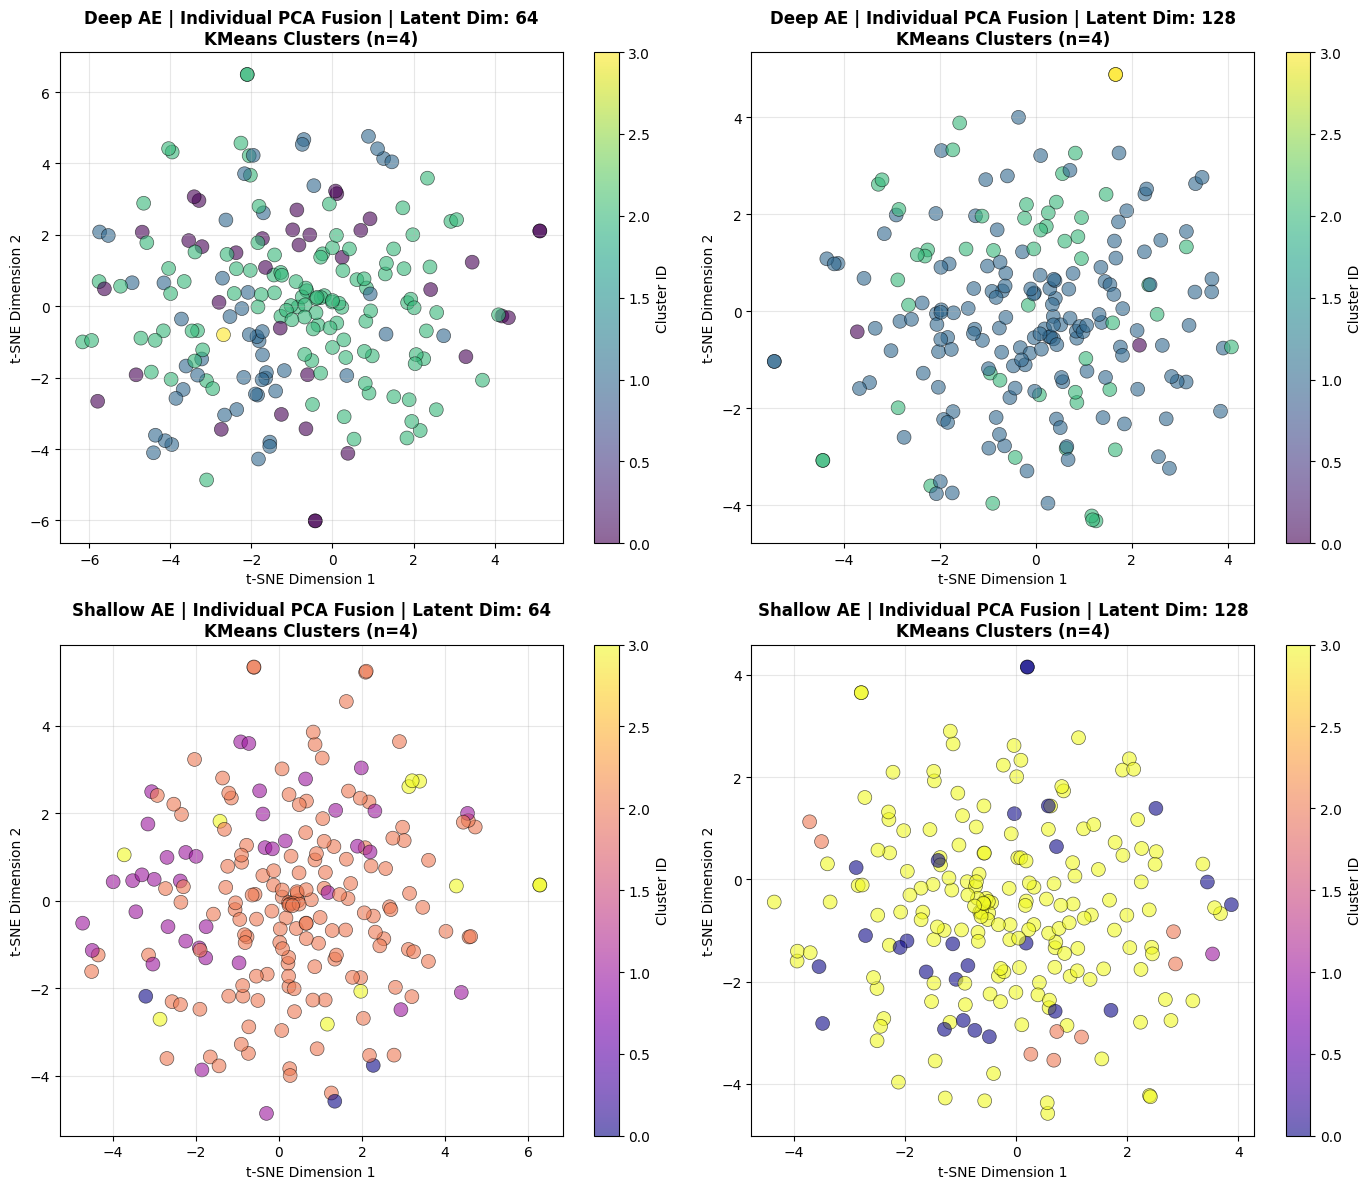


✅ Visualization completed for 2 latent dimensions!
   Top row: Deep Autoencoder (Input → 256 → Latent → 256 → Output)
   Bottom row: Shallow Autoencoder (Input → Latent → Output)
   Each plot shows KMeans clustering in 2D space (via t-SNE)


In [34]:

# VISUALIZATION: Deep and Shallow Autoencoder Comparisons
print("=" * 100)
print("📊 AUTOENCODER VISUALIZATION COMPARISON")
print("=" * 100)

n_latents = len(ae_scores)
fig, axes = plt.subplots(2, n_latents, figsize=(7 * n_latents, 12))

# Handle single latent dimension case
if n_latents == 1:
    axes = axes.reshape(-1, 1)

y = labels.values.ravel()
n_clusters = len(np.unique(y))

for idx, latent_dim in enumerate(ae_scores.keys()):
    # ============================================================================
    # DEEP AUTOENCODER VISUALIZATION
    # ============================================================================
    # Get deep autoencoder embeddings
    embeddings_deep_np = ae_embeddings[latent_dim]
    
    # Apply t-SNE for 2D visualization (if latent_dim > 2)
    if latent_dim > 2:
        tsne_deep = TSNE(n_components=2, random_state=42, perplexity=min(30, len(embeddings_deep_np)-1))
        embeddings_deep_2d = tsne_deep.fit_transform(embeddings_deep_np)
    else:
        embeddings_deep_2d = embeddings_deep_np[:, :2]
    
    # Use KMeans for cluster assignment
    kmeans_deep = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels_deep = kmeans_deep.fit_predict(embeddings_deep_np)
    
    # Plot deep autoencoder
    ax_deep = axes[0, idx]
    scatter_deep = ax_deep.scatter(embeddings_deep_2d[:, 0], embeddings_deep_2d[:, 1], 
                                  c=cluster_labels_deep, cmap='viridis', 
                                  s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
    
    ax_deep.set_title(f'Deep AE | Individual PCA Fusion | Latent Dim: {latent_dim}\nKMeans Clusters (n={n_clusters})', 
                     fontsize=12, fontweight='bold')
    ax_deep.set_xlabel('t-SNE Dimension 1' if latent_dim > 2 else 'Latent Dimension 1', fontsize=10)
    ax_deep.set_ylabel('t-SNE Dimension 2' if latent_dim > 2 else 'Latent Dimension 2', fontsize=10)
    ax_deep.grid(True, alpha=0.3)
    plt.colorbar(scatter_deep, ax=ax_deep, label='Cluster ID')
    
    # ============================================================================
    # SHALLOW AUTOENCODER VISUALIZATION
    # ============================================================================
    # Get shallow autoencoder embeddings
    embeddings_shallow_np = shallow_ae_embeddings[latent_dim]
    
    # Apply t-SNE for 2D visualization (if latent_dim > 2)
    if latent_dim > 2:
        tsne_shallow = TSNE(n_components=2, random_state=42, perplexity=min(30, len(embeddings_shallow_np)-1))
        embeddings_shallow_2d = tsne_shallow.fit_transform(embeddings_shallow_np)
    else:
        embeddings_shallow_2d = embeddings_shallow_np[:, :2]
    
    # Use KMeans for cluster assignment
    kmeans_shallow = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels_shallow = kmeans_shallow.fit_predict(embeddings_shallow_np)
    
    # Plot shallow autoencoder
    ax_shallow = axes[1, idx]
    scatter_shallow = ax_shallow.scatter(embeddings_shallow_2d[:, 0], embeddings_shallow_2d[:, 1], 
                                       c=cluster_labels_shallow, cmap='plasma', 
                                       s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
    
    ax_shallow.set_title(f'Shallow AE | Individual PCA Fusion | Latent Dim: {latent_dim}\nKMeans Clusters (n={n_clusters})', 
                        fontsize=12, fontweight='bold')
    ax_shallow.set_xlabel('t-SNE Dimension 1' if latent_dim > 2 else 'Latent Dimension 1', fontsize=10)
    ax_shallow.set_ylabel('t-SNE Dimension 2' if latent_dim > 2 else 'Latent Dimension 2', fontsize=10)
    ax_shallow.grid(True, alpha=0.3)
    plt.colorbar(scatter_shallow, ax=ax_shallow, label='Cluster ID')

plt.tight_layout()
plt.show()

print(f"\n✅ Visualization completed for {n_latents} latent dimensions!")
print(f"   Top row: Deep Autoencoder (Input → 256 → Latent → 256 → Output)")
print(f"   Bottom row: Shallow Autoencoder (Input → Latent → Output)")
print(f"   Each plot shows KMeans clustering in 2D space (via t-SNE)")

In [35]:
# Display Evaluation Results in Tables
print("=" * 100)
print("📊 DEEP AUTOENCODER PIPELINE EVALUATION RESULTS")
print("=" * 100)

# ============================================================================
# TABLE 1: DEEP AE - ML MODEL PERFORMANCE METRICS
# ============================================================================
print("\n" + "=" * 100)
print("TABLE 1: DEEP AUTOENCODER - MACHINE LEARNING MODEL PERFORMANCE")
print("=" * 100)

# Collect all ML model results for deep autoencoder
ml_results_table_deep = []

for latent_dim, results in ae_scores.items():
    for model_name, metrics in results['ml_models'].items():
        row = {
            'Latent Dim': latent_dim,
            'Model': model_name,
            'Accuracy': metrics['accuracy'],
            'F1-Macro': metrics['f1_macro'],
            'F1-Micro': metrics['f1_micro'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'AUC': metrics['auc'] if metrics['auc'] is not None else np.nan,
            'C-Index': metrics['c_index'] if metrics['c_index'] is not None else np.nan,
            'CV-Mean': metrics['cv_mean'],
            'CV-Std': metrics['cv_std']
        }
        ml_results_table_deep.append(row)

# Create DataFrame
ml_df_deep = pd.DataFrame(ml_results_table_deep)

# Display full table with proper formatting
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.4f}'.format)

print("\n📋 Deep AE Complete ML Model Performance Table:")
print("-" * 100)
print(ml_df_deep.to_string(index=False))

# ============================================================================
# TABLE 2: DEEP AE - STABILITY & CLUSTERING METRICS
# ============================================================================
print("\n\n" + "=" * 100)
print("TABLE 2: DEEP AUTOENCODER - STABILITY & CLUSTERING METRICS")
print("=" * 100)

# Collect stability metrics for deep autoencoder
stability_table_deep = []

for latent_dim, results in ae_scores.items():
    row = {
        'Latent Dim': latent_dim,
        'ARI': results['ari'],
        'NMI': results['nmi'],
        'Silhouette': results['silhouette'],
        'Calinski-Harabasz': results['calinski_harabasz'],
        'Davies-Bouldin': results['davies_bouldin'],
        'Reconstruction Error': results['reconstruction_error'],
        'Embedding Shape': f"{results['embeddings_shape'][0]}x{results['embeddings_shape'][1]}"
    }
    stability_table_deep.append(row)

# Create DataFrame
stability_df_deep = pd.DataFrame(stability_table_deep)

print("\n📋 Deep AE Complete Stability & Clustering Metrics Table:")
print("-" * 100)
print(stability_df_deep.to_string(index=False))

📊 DEEP AUTOENCODER PIPELINE EVALUATION RESULTS

TABLE 1: DEEP AUTOENCODER - MACHINE LEARNING MODEL PERFORMANCE

📋 Deep AE Complete ML Model Performance Table:
----------------------------------------------------------------------------------------------------
 Latent Dim              Model  Accuracy  F1-Macro  F1-Micro  Precision  Recall    AUC  C-Index  CV-Mean  CV-Std
         64       RandomForest    0.6341    0.4067    0.6341     0.5859  0.4221 0.8172   0.4903   0.5902  0.0358
         64   GradientBoosting    0.5122    0.3333    0.5122     0.3238  0.3467 0.7118   0.4356   0.4488  0.0647
         64 LogisticRegression    0.7073    0.6171    0.7073     0.6124  0.6341 0.8392   0.5026   0.6244  0.1030
         64            SVM_RBF    0.6098    0.3503    0.6098     0.3250  0.3959 0.8648   0.4533   0.6293  0.0284
         64                KNN    0.5122    0.3698    0.5122     0.3661  0.4118 0.6867   0.4709   0.5610  0.0556
         64         NaiveBayes    0.4146    0.3130    0.4146  

In [36]:
# Display Shallow Autoencoder Results in Separate Tables
print("=" * 100)
print("📊 SHALLOW AUTOENCODER PIPELINE EVALUATION RESULTS")
print("=" * 100)

# ============================================================================
# TABLE 3: SHALLOW AE - ML MODEL PERFORMANCE METRICS
# ============================================================================
print("\n" + "=" * 100)
print("TABLE 3: SHALLOW AUTOENCODER - MACHINE LEARNING MODEL PERFORMANCE")
print("=" * 100)

# Collect all ML model results for shallow autoencoder
ml_results_table_shallow = []

for latent_dim, results in shallow_ae_scores.items():
    for model_name, metrics in results['ml_models'].items():
        row = {
            'Latent Dim': latent_dim,
            'Model': model_name,
            'Accuracy': metrics['accuracy'],
            'F1-Macro': metrics['f1_macro'],
            'F1-Micro': metrics['f1_micro'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'AUC': metrics['auc'] if metrics['auc'] is not None else np.nan,
            'C-Index': metrics['c_index'] if metrics['c_index'] is not None else np.nan,
            'CV-Mean': metrics['cv_mean'],
            'CV-Std': metrics['cv_std']
        }
        ml_results_table_shallow.append(row)

# Create DataFrame
ml_df_shallow = pd.DataFrame(ml_results_table_shallow)

print("\n📋 Shallow AE Complete ML Model Performance Table:")
print("-" * 100)
print(ml_df_shallow.to_string(index=False))

# ============================================================================
# TABLE 4: SHALLOW AE - STABILITY & CLUSTERING METRICS
# ============================================================================
print("\n\n" + "=" * 100)
print("TABLE 4: SHALLOW AUTOENCODER - STABILITY & CLUSTERING METRICS")
print("=" * 100)

# Collect stability metrics for shallow autoencoder
stability_table_shallow = []

for latent_dim, results in shallow_ae_scores.items():
    row = {
        'Latent Dim': latent_dim,
        'ARI': results['ari'],
        'NMI': results['nmi'],
        'Silhouette': results['silhouette'],
        'Calinski-Harabasz': results['calinski_harabasz'],
        'Davies-Bouldin': results['davies_bouldin'],
        'Reconstruction Error': results['reconstruction_error'],
        'Embedding Shape': f"{results['embeddings_shape'][0]}x{results['embeddings_shape'][1]}"
    }
    stability_table_shallow.append(row)

# Create DataFrame
stability_df_shallow = pd.DataFrame(stability_table_shallow)

print("\n📋 Shallow AE Complete Stability & Clustering Metrics Table:")
print("-" * 100)
print(stability_df_shallow.to_string(index=False))

# ============================================================================
# COMPARISON SUMMARY: DEEP vs SHALLOW AUTOENCODER
# ============================================================================
print("\n\n" + "=" * 100)
print("📊 ARCHITECTURE COMPARISON SUMMARY")
print("=" * 100)

print("\n🏗️  Architecture Details:")
print("   Deep AE:    Input → 256 → Latent → 256 → Output (2 hidden layers)")
print("   Shallow AE: Input → Latent → Output (0 hidden layers)")

print("\n📈 Performance Summary by Latent Dimension:")
print("-" * 100)

for latent_dim in ae_scores.keys():
    print(f"\n📊 Latent Dimension: {latent_dim}")
    print("-" * 50)
    
    # Get best performing model for each architecture
    deep_results = ae_scores[latent_dim]['ml_models']
    shallow_results = shallow_ae_scores[latent_dim]['ml_models']
    
    # Find best accuracy for each
    deep_best_acc = max([metrics['accuracy'] for metrics in deep_results.values()])
    shallow_best_acc = max([metrics['accuracy'] for metrics in shallow_results.values()])
    
    deep_best_f1 = max([metrics['f1_macro'] for metrics in deep_results.values()])
    shallow_best_f1 = max([metrics['f1_macro'] for metrics in shallow_results.values()])
    
    print(f"   Deep AE    - Best Accuracy: {deep_best_acc:.4f} | Best F1-Macro: {deep_best_f1:.4f}")
    print(f"   Shallow AE - Best Accuracy: {shallow_best_acc:.4f} | Best F1-Macro: {shallow_best_f1:.4f}")
    
    # Clustering comparison
    print(f"   Deep AE    - ARI: {ae_scores[latent_dim]['ari']:.4f} | Silhouette: {ae_scores[latent_dim]['silhouette']:.4f}")
    print(f"   Shallow AE - ARI: {shallow_ae_scores[latent_dim]['ari']:.4f} | Silhouette: {shallow_ae_scores[latent_dim]['silhouette']:.4f}")
    
    # Reconstruction error comparison
    print(f"   Deep AE    - Recon Error: {ae_scores[latent_dim]['reconstruction_error']:.6f}")
    print(f"   Shallow AE - Recon Error: {shallow_ae_scores[latent_dim]['reconstruction_error']:.6f}")

print(f"\n{'='*100}")
print(f"✅ COMPARATIVE ANALYSIS COMPLETED!")
print(f"{'='*100}")

📊 SHALLOW AUTOENCODER PIPELINE EVALUATION RESULTS

TABLE 3: SHALLOW AUTOENCODER - MACHINE LEARNING MODEL PERFORMANCE

📋 Shallow AE Complete ML Model Performance Table:
----------------------------------------------------------------------------------------------------
 Latent Dim              Model  Accuracy  F1-Macro  F1-Micro  Precision  Recall    AUC  C-Index  CV-Mean  CV-Std
         64       RandomForest    0.5854    0.3757    0.5854     0.4697  0.3862 0.7479   0.4885   0.5707  0.0396
         64   GradientBoosting    0.5610    0.4148    0.5610     0.4201  0.4181 0.6787   0.4215   0.5268  0.0396
         64 LogisticRegression    0.5854    0.4485    0.5854     0.4387  0.4634 0.7942   0.4409   0.5659  0.0762
         64            SVM_RBF    0.5610    0.3030    0.5610     0.3784  0.3409 0.7803   0.4056   0.5707  0.0396
         64                KNN    0.3659    0.2646    0.3659     0.4271  0.3060 0.6383   0.4480   0.4488  0.0502
         64         NaiveBayes    0.4390    0.3165   

📈 AUC-ROC CURVES FOR DEEP AND SHALLOW AUTOENCODERS


f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATA

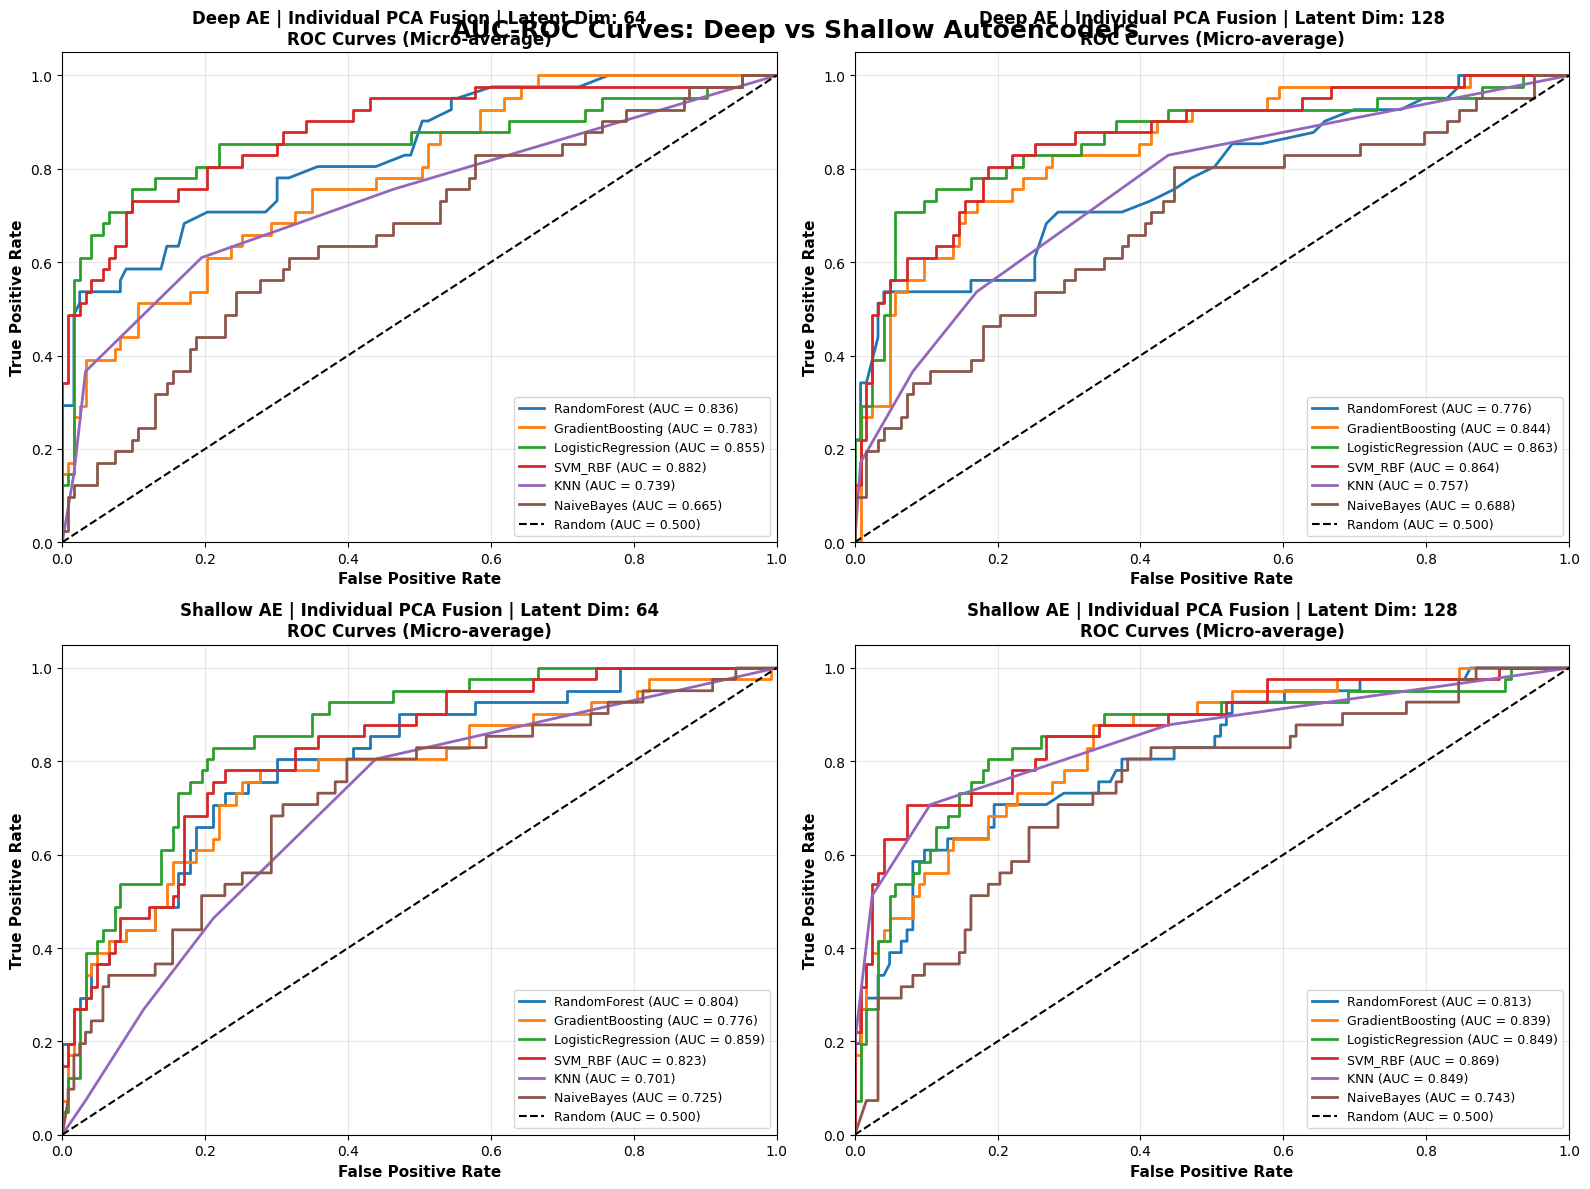


✅ ROC curves plotted for 2 latent dimensions!
   Top row: Deep Autoencoder (Input → 256 → Latent → 256 → Output)
   Bottom row: Shallow Autoencoder (Input → Latent → Output)
   Each subplot shows all 6 models for comparison
   Multiclass (micro-average) ROC curves

📊 AUC SUMMARY TABLES

📋 Deep AE - AUC Scores by Configuration and Model:
----------------------------------------------------------------------------------------------------
 Latent Dim              Model    AUC
         64       RandomForest 0.8172
         64   GradientBoosting 0.7118
         64 LogisticRegression 0.8392
         64            SVM_RBF 0.8648
         64                KNN 0.6867
         64         NaiveBayes 0.5653
        128       RandomForest 0.7102
        128   GradientBoosting 0.8065
        128 LogisticRegression 0.8149
        128            SVM_RBF 0.8549
        128                KNN 0.7009
        128         NaiveBayes 0.6241

📋 Shallow AE - AUC Scores by Configuration and Model:
----------

In [37]:
# Plot AUC-ROC Curves for Deep and Shallow Autoencoders
print("=" * 100)
print("📈 AUC-ROC CURVES FOR DEEP AND SHALLOW AUTOENCODERS")
print("=" * 100)

from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Get latent dimensions
latent_dims = list(ae_scores.keys())
n_latents = len(latent_dims)

# Create subplots: 2 rows (Deep, Shallow) x n_latents columns
fig, axes = plt.subplots(2, n_latents, figsize=(8 * n_latents, 12))

# Handle single latent dimension case
if n_latents == 1:
    axes = axes.reshape(-1, 1)

# Get labels and classes
y = labels.values.ravel()
classes = np.unique(y)
n_classes = len(classes)

for idx, latent_dim in enumerate(latent_dims):
    
    # ============================================================================
    # DEEP AUTOENCODER ROC CURVES
    # ============================================================================
    ax_deep = axes[0, idx]
    deep_results = ae_scores[latent_dim]
    embeddings_deep_np = ae_embeddings[latent_dim]
    
    # Store model colors for consistency
    model_colors = {}
    color_iter = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'])
    
    for model_name in deep_results['ml_models'].keys():
        model_colors[model_name] = next(color_iter)
    
    # Train each model and plot ROC curve for deep autoencoder
    for model_name, metrics in deep_results['ml_models'].items():
        # Define model
        if model_name == 'RandomForest':
            model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
        elif model_name == 'GradientBoosting':
            model = GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=5)
        elif model_name == 'LogisticRegression':
            model = LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr')
        elif model_name == 'SVM_RBF':
            model = SVC(kernel='rbf', random_state=42, probability=True)
        elif model_name == 'KNN':
            model = KNeighborsClassifier(n_neighbors=4)
        elif model_name == 'NaiveBayes':
            model = GaussianNB()
        
        # Split data for proper evaluation
        X_train, X_test, y_train, y_test = train_test_split(
            embeddings_deep_np, y, test_size=0.2, random_state=42, stratify=y
        )
        
        # Train and predict
        model.fit(X_train, y_train)
        y_score = model.predict_proba(X_test)
        
        # Compute ROC curve
        if n_classes == 2:
            y_test_bin = label_binarize(y_test, classes=classes)
            fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score[:, 1])
            roc_auc = auc(fpr, tpr)
            ax_deep.plot(fpr, tpr, color=model_colors[model_name], lw=2,
                        label=f'{model_name} (AUC = {roc_auc:.3f})')
        else:
            y_test_bin = label_binarize(y_test, classes=classes)
            fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
            roc_auc = auc(fpr, tpr)
            ax_deep.plot(fpr, tpr, color=model_colors[model_name], lw=2,
                        label=f'{model_name} (AUC = {roc_auc:.3f})')
    
    # Plot diagonal line for deep AE
    ax_deep.plot([0, 1], [0, 1], 'k--', lw=1.5, label='Random (AUC = 0.500)')
    
    # Formatting for deep AE
    ax_deep.set_xlim([0.0, 1.0])
    ax_deep.set_ylim([0.0, 1.05])
    ax_deep.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
    ax_deep.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
    ax_deep.set_title(f'Deep AE | Individual PCA Fusion | Latent Dim: {latent_dim}\nROC Curves ({"Binary" if n_classes == 2 else "Micro-average"})', 
                     fontsize=12, fontweight='bold')
    ax_deep.legend(loc="lower right", fontsize=9)
    ax_deep.grid(True, alpha=0.3)
    
    # ============================================================================
    # SHALLOW AUTOENCODER ROC CURVES
    # ============================================================================
    ax_shallow = axes[1, idx]
    shallow_results = shallow_ae_scores[latent_dim]
    embeddings_shallow_np = shallow_ae_embeddings[latent_dim]
    
    # Train each model and plot ROC curve for shallow autoencoder
    for model_name, metrics in shallow_results['ml_models'].items():
        # Define model (same as above)
        if model_name == 'RandomForest':
            model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
        elif model_name == 'GradientBoosting':
            model = GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=5)
        elif model_name == 'LogisticRegression':
            model = LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr')
        elif model_name == 'SVM_RBF':
            model = SVC(kernel='rbf', random_state=42, probability=True)
        elif model_name == 'KNN':
            model = KNeighborsClassifier(n_neighbors=4)
        elif model_name == 'NaiveBayes':
            model = GaussianNB()
        
        # Split data for proper evaluation
        X_train, X_test, y_train, y_test = train_test_split(
            embeddings_shallow_np, y, test_size=0.2, random_state=42, stratify=y
        )
        
        # Train and predict
        model.fit(X_train, y_train)
        y_score = model.predict_proba(X_test)
        
        # Compute ROC curve
        if n_classes == 2:
            y_test_bin = label_binarize(y_test, classes=classes)
            fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score[:, 1])
            roc_auc = auc(fpr, tpr)
            ax_shallow.plot(fpr, tpr, color=model_colors[model_name], lw=2,
                           label=f'{model_name} (AUC = {roc_auc:.3f})')
        else:
            y_test_bin = label_binarize(y_test, classes=classes)
            fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
            roc_auc = auc(fpr, tpr)
            ax_shallow.plot(fpr, tpr, color=model_colors[model_name], lw=2,
                           label=f'{model_name} (AUC = {roc_auc:.3f})')
    
    # Plot diagonal line for shallow AE
    ax_shallow.plot([0, 1], [0, 1], 'k--', lw=1.5, label='Random (AUC = 0.500)')
    
    # Formatting for shallow AE
    ax_shallow.set_xlim([0.0, 1.0])
    ax_shallow.set_ylim([0.0, 1.05])
    ax_shallow.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
    ax_shallow.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
    ax_shallow.set_title(f'Shallow AE | Individual PCA Fusion | Latent Dim: {latent_dim}\nROC Curves ({"Binary" if n_classes == 2 else "Micro-average"})', 
                        fontsize=12, fontweight='bold')
    ax_shallow.legend(loc="lower right", fontsize=9)
    ax_shallow.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('AUC-ROC Curves: Deep vs Shallow Autoencoders', 
            fontsize=18, fontweight='bold', y=0.98)
plt.show()

print(f"\n✅ ROC curves plotted for {n_latents} latent dimensions!")
print(f"   Top row: Deep Autoencoder (Input → 256 → Latent → 256 → Output)")
print(f"   Bottom row: Shallow Autoencoder (Input → Latent → Output)")
print(f"   Each subplot shows all 6 models for comparison")
print(f"   {"Binary classification" if n_classes == 2 else "Multiclass (micro-average) ROC curves"}")

# ============================================================================
# Summary Tables: AUC Scores for Deep and Shallow Autoencoders
# ============================================================================
print("\n" + "=" * 100)
print("📊 AUC SUMMARY TABLES")
print("=" * 100)

# Deep AE AUC Summary
auc_summary_deep = []
for latent_dim in latent_dims:
    results = ae_scores[latent_dim]
    
    for model_name, metrics in results['ml_models'].items():
        auc_val = metrics['auc'] if metrics['auc'] is not None else np.nan
        auc_summary_deep.append({
            'Latent Dim': latent_dim,
            'Model': model_name,
            'AUC': auc_val
        })

auc_df_deep = pd.DataFrame(auc_summary_deep)
print("\n📋 Deep AE - AUC Scores by Configuration and Model:")
print("-" * 100)
print(auc_df_deep.to_string(index=False))

# Shallow AE AUC Summary
auc_summary_shallow = []
for latent_dim in latent_dims:
    results = shallow_ae_scores[latent_dim]
    
    for model_name, metrics in results['ml_models'].items():
        auc_val = metrics['auc'] if metrics['auc'] is not None else np.nan
        auc_summary_shallow.append({
            'Latent Dim': latent_dim,
            'Model': model_name,
            'AUC': auc_val
        })

auc_df_shallow = pd.DataFrame(auc_summary_shallow)
print("\n📋 Shallow AE - AUC Scores by Configuration and Model:")
print("-" * 100)
print(auc_df_shallow.to_string(index=False))